In [1]:
import argparse
import os
import re
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
import skimage
import skimage.draw
import geopandas as gpd
import pyproj
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

### Clip the study region

In [2]:
img_dir = 'N:/dataorg-datasets/MLsatellite/sentinel2_images/images_danya/'
images_dir = 'N:/dataorg-datasets/MLsatellite/sentinel2_images/images_danya/'

In [5]:
def dropna_in_shapefile(from_shp_path, to_shp_path=None):
    shapefile = gpd.read_file(from_shp_path)
    shapefile = shapefile.dropna().reset_index(drop=True)
    if to_shp_path is None:
        shapefile.to_file(from_shp_path)
    else:
        shapefile.to_file(to_shp_path)

In [6]:
dropna_in_shapefile('../data/labels/labels.shp', '../data/labels/labels_dropna.shp')

In [8]:
def clip_all_rasters(images_dir, shape_filepath='../data/study-area/study_area.shp'):
    # shape file information
    with fiona.open(shape_filepath, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile if feature["geometry"] is not None]
    shape_crs = gpd.read_file(shape_filepath).crs

    # geotiff directory
    geotiff_dir = images_dir + 'geotiff/'
    # clip directory
    clip_dir = images_dir + 'clip/'
    if not os.path.exists(clip_dir):
        os.mkdir(clip_dir)

    # clip all the raster
    for filename in [f for f in os.listdir(geotiff_dir) if f.endswith('.tiff')]:
        geotiff_filepath = geotiff_dir + filename
        clip_filepath = clip_dir + filename
        clip_single_raster(shape_crs, shapes, geotiff_filepath, clip_filepath)


def clip_single_raster(shape_crs, shapes, geotiff_filepath, clip_filepath):
    # get the coordinate system of raster
    raster = rasterio.open(geotiff_filepath)

    # check if two coordinate systems are the same
    if shape_crs != raster.crs:
        reproject_single_raster(shape_crs, geotiff_filepath, clip_filepath)
        # read imagery file
        with rasterio.open(clip_filepath) as src:
            out_image, out_transform = mask(src, shapes, crop=True)
            out_meta = src.meta
    else:
        # read imagery file
        with rasterio.open(geotiff_filepath) as src:
            out_image, out_transform = mask(src, shapes, crop=True)
            out_meta = src.meta

    # Save clipped imagery
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(clip_filepath, "w", **out_meta) as dest:
        # out_image.shape (band, height, width)
        dest.write(out_image)


def reproject_single_raster(dst_crs, input_file, transformed_file):
    """
    :param dst_crs: output projection system
    :param input_file
    :param transformed_file
    :return:
    """
    with rasterio.open(input_file) as imagery:
        transform, width, height = calculate_default_transform(imagery.crs, dst_crs, imagery.width, imagery.height,
                                                               *imagery.bounds)
        kwargs = imagery.meta.copy()
        kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})
        with rasterio.open(transformed_file, 'w', **kwargs) as dst:
            for i in range(1, imagery.count + 1):
                reproject(
                    source=rasterio.band(imagery, i),
                    destination=rasterio.band(dst, i),
                    src_transform=imagery.transform,
                    src_crs=imagery.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [ ]:
clip_all_rasters(img_dir)

In [710]:
def normalize(array):
    array_min, array_max = array.min(), 2000
    return (array - array_min) / (array_max - array_min + 1e-6)

def show_true_color(raster, is_norm=True):
    # Convert to numpy arrays
    blue = raster.read(1)
    green = raster.read(2)
    red = raster.read(3)
    
    # Normalize bands into 0.0 - 1.0 scale
    if is_norm:
        blue = normalize(blue)
        green = normalize(green)
        red = normalize(red)

    # Stack bands
    img_rgb = np.dstack((red, green, blue))

    # View the color composite
    fig = plt.subplots(figsize=(7,7))
    plt.imshow(img_rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


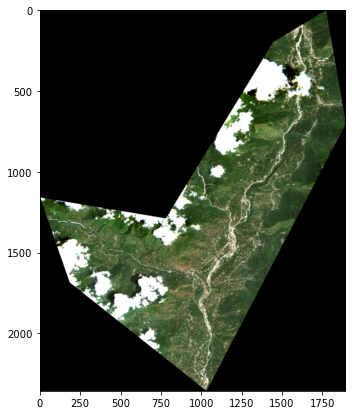

In [714]:
# show an example 
example = rasterio.open(img_dir+'clip/L2A_T43SFR_A026271_20200703T053446.tiff')
show_true_color(example, is_norm=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


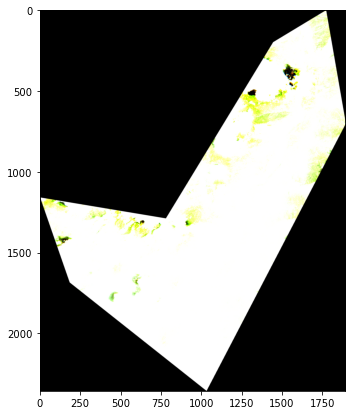

In [715]:
show_true_color(example, is_norm=False)

In [19]:
print(f'The example has {example.count} bands.')

The example has 4 bands.


### Read images

For classic classifiers, no need to crop into patches since model.fit(x) requires all the training data points.

In [7]:
def load_geotiff(path, window=None):
    """ Load the geotiff as a list of numpy array.
        INPUT : path (str) -> the path to the geotiff
                window (raterio.windows.Window) -> the window to use when loading the image
        OUTPUT : band (list of numpy array) -> the different bands as float scalled to 0:1
                 meta (dictionnary) -> the metadata associated with the geotiff
    """
    with rasterio.open(path) as f:
        band = [skimage.img_as_float(f.read(i+1, window=window)) for i in range(f.count)]
        meta = f.meta
        if window != None:
            meta['height'] = window.height
            meta['width'] = window.width
            meta['transform'] = f.window_transform(window)
    return band, meta

In [3]:
def stack_all_timestamps(from_dir):
    # stack images of different timestamp
    stacked_raster = dict(band=[], meta=[], timestamp=[])
    for filename in os.listdir(from_dir):
        raster_filepath = from_dir + filename
        band, meta = load_geotiff(raster_filepath)
        timestamp = re.split('[_.]', filename)[-2]
        stacked_raster['band'].append(np.stack(band, axis=2))
        stacked_raster['meta'] = meta
        stacked_raster['timestamp'].append(datetime.strptime(timestamp, '%Y%m%dT%H%M%S%f'))
    return stacked_raster 

In [6]:
# stack the images of all timestamps
stacked_raster = stack_all_timestamps(images_dir + 'clip/')
stacked_band = np.array(stacked_raster['band'])
meta_train = stacked_raster['meta']
stacked_timestamp = stacked_raster['timestamp']
print(stacked_band.shape)

(61, 2357, 1892, 4)


In [93]:
def plot_timestamps(timestamps, save_path=None):
    fig, ax = plt.subplots(1,1,figsize=(12,0.4))
    plt.plot_date(timestamps, np.ones(len(timestamps)), '|', markersize=20)
    plt.xlim(datetime(2020,1,1), datetime(2020,12,31))
    ax.axes.get_yaxis().set_visible(False)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    # ax.spines['left'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    # plt.axis('off')
    # plt.tick_params(axis='both', left='off', top='off', right='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

In [83]:
# def equidistant_stack(from_dir):
#     bands_list, timestamps_b = [], []
#     for filename in os.listdir(from_dir):
#         raster_filepath = from_dir + filename
#         band, meta = load_geotiff(raster_filepath)
#         timestamp = datetime.strptime(re.split('[_.]', filename)[-2], '%Y%m%dT%H%M%S%f').date()
#         df_band = pd.DataFrame(np.stack(band, axis=2).reshape(-1, len(band)), 
#                                columns=['blue', 'green', 'red', 'nir']).reset_index()
#         df_band['time'] = timestamp
#         bands_list.append(df_band)
#         timestamps_b.append(timestamp)
#     df_bands = pd.concat(bands_list, ignore_index=True)
#     timestamps_a = [ts - timedelta(days=ts.weekday()) for ts in timestamps_b]
#     return df_bands, meta, timestamps_b, timestamps_a

In [3]:
def get_weekly_timestamps():
    date_start = date(2020, 1, 1)
    date_end = date(2020, 12, 31)
    date_start = date_start - timedelta(days=date_start.weekday())
    date_end = date_end - timedelta(days=date_end.weekday())
    d = date_start
    weekly_timestamps = []
    while d <= date_end:
        weekly_timestamps.append(d)
        d += timedelta(7)
    return weekly_timestamps

In [4]:
def timestamp_sanity_check(timestamp_std, filename):
    timestamp_get = datetime.strptime(re.split('[_.]', filename)[-2],
                                      '%Y%m%dT%H%M%S%f').date()
    timestamp_get = timestamp_get - timedelta(days=timestamp_get.weekday())
    if timestamp_std != timestamp_get:
        print(f'{timestamp_std} and {timestamp_get} do not match!')

In [5]:
def equidistant_stack(from_dir):

    # check all the timestamps, and find the corresponding Mon.
    timestamps_bf = []
    for filename in sorted(os.listdir(from_dir)):
        timestamps_bf.append(datetime.strptime(re.split('[_.]', filename)[-2],
                                               '%Y%m%dT%H%M%S%f').date())
    timestamps_af = [ts - timedelta(days=ts.weekday()) for ts in timestamps_bf]
    timestamps_weekly = get_weekly_timestamps()

    # get the data shape
    _, meta = load_geotiff(from_dir + os.listdir(from_dir)[0])

    # stack equidistantly
    timestamps_af_pd = pd.Series(timestamps_af)
    bands_list = []
    for timestamp in timestamps_weekly:
        # get all the indices of that week
        ids = timestamps_af_pd[timestamps_af_pd.eq(timestamp)].index
        # deal with empty week
        if len(ids) == 0:
            bands_list.append(np.zeros((meta['height'] * meta['width'], meta['count'])))
        elif len(ids) == 1:
            # read band
            filename = sorted(os.listdir(from_dir))[ids[0]]
            raster_filepath = from_dir + filename
            band, _ = load_geotiff(raster_filepath)
            # sanity check
            timestamp_sanity_check(timestamp, raster_filepath)
            # pixel values check
            if np.array(band).mean() != 0.0:
                # store
                bands_list.append(np.stack(band, axis=2).reshape(-1, len(band)))
            else:
                print(f'Discard {filename} due to 0 values.')
        else:
            band_list = []
            for id in ids:
                # read band
                filename = sorted(os.listdir(from_dir))[id]
                raster_filepath = from_dir + filename
                band, meta = load_geotiff(raster_filepath)
                # sanity check
                timestamp_sanity_check(timestamp, raster_filepath)
                # pixel values check
                if np.array(band).mean() != 0.0:
                    # store
                    band_list.append(np.stack(band, axis=2).reshape(-1, len(band)))
                else:
                    print(f'Discard {filename} due to 0 values.')
            bands_list.append(np.stack(band_list, axis=2).mean(axis=2))

    return bands_list, meta, timestamps_bf, timestamps_af, timestamps_weekly

In [8]:
bands_list, meta_train, timestamps_bf, timestamps_af, timestamps_weekly = \
    equidistant_stack(images_dir+'clip_labels/')

Discard L2A_T43SFR_A026457_20200716T054714.tiff due to 0 values.
Discard L2A_T43SFR_A026600_20200726T054429.tiff due to 0 values.


In [148]:
np.stack(bands_list, axis=2).shape

(2627429, 4, 53)

In [146]:
np.stack(bands_list, axis=2).mean(axis=(0,1))

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00018625, 0.        , 0.00017265, 0.00017559,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

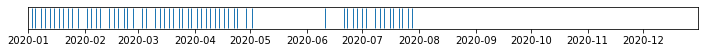

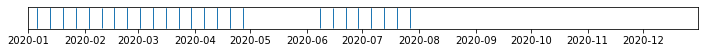

In [94]:
plot_timestamps(timestamps_bf, '../figs/timestamps_bf.png')
plot_timestamps(timestamps_af, '../figs/timestamps_af.png')

In [21]:
def get_raw_features(num_of_weeks, bands_list):
    df_raw = pd.DataFrame()
    for i in range(num_of_weeks):
        new_col_name = [n + '_' + str(i+1) for n in ['blue', 'green', 'red', 'nir']]
        df_raw[new_col_name] = bands_list[i]
    return df_raw 


def compute_statistics(op, data):
    if op == 'avg':
        return data.mean(axis=1)
    elif op == 'std':
        return data.std(axis=1)
    elif op == 'max':
        return data.max(axis=1)
    else:
        return 'No corresponding calculation.'
    
    
def get_statistics_by_band(band, num_of_weeks, df):
    cols = [band+'_'+str(i+1) for i in range(num_of_weeks)]
    df_new = pd.DataFrame()
    for op in ['avg', 'std', 'max']:
        col_name = band + '_' + op
        df_new[col_name] = compute_statistics(op, df[cols])
    return df_new


def get_statistics(bands, num_of_weeks, df):
    df_new_list = []
    for band in bands:
        df_new_list.append(get_statistics_by_band(band, num_of_weeks, df))
    df_new = pd.concat(df_new_list, axis=1)
    return df_new    
    

def get_difference_by_band(band, num_of_weeks, df):
    df_new = pd.DataFrame()
    for i in range(1, num_of_weeks):
        df_new[band+'_diff_'+str(i)] = df[band+'_'+str(i+1)] - df[band+'_'+str(i)]
    return df_new


def get_difference(bands, num_of_weeks, df):
    df_new_list = []
    for band in bands:
        df_new_list.append(get_difference_by_band(band, num_of_weeks, df))
    df_new = pd.concat(df_new_list, axis=1)
    return df_new   

In [28]:
num_of_weeks = len(timestamps_weekly)
bands = ['blue', 'green', 'red', 'nir']
df = get_raw_features(num_of_weeks, bands_list)
df_list = [df]
df_list.append(get_statistics(bands, num_of_weeks, df))
df_list.append(get_difference(bands, num_of_weeks, df))
df = pd.concat(df_list, axis=1)
df

C:\Users\lida\Anaconda3\envs\ml4sat\lib\site-packages\pandas\core\frame.py:3673: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,blue_1,green_1,red_1,nir_1,blue_2,green_2,red_2,nir_2,blue_3,green_3,...,nir_diff_43,nir_diff_44,nir_diff_45,nir_diff_46,nir_diff_47,nir_diff_48,nir_diff_49,nir_diff_50,nir_diff_51,nir_diff_52
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2627425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2627426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2627427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
def add_features(img, new_features=['ndvi']):
    """
    band02 = blue --> idx = 0
    band03 = green --> idx = 1
    band04 = red --> idx = 2
    band08 = nir --> idx = 3
    """
    new_bands = []
    
    # bands
    blue = img[:, 0]
    green = img[:, 1]
    red = img[:, 2]
    nir = img[:, 3]

    # add feature
    for feature in new_features:
        if feature == 'ndvi':
            new_bands.append(calculate_ndvi(red, nir))
        elif feature == 'gndvi':
            new_bands.append(calculate_gndvi(green, nir))
        elif feature == 'evi':
            new_bands.append(calculate_evi(blue, blue, nir))
        elif feature == 'cvi':
            new_bands.append(calculate_cvi(green, red, nir))

    return np.append(img, np.stack(new_bands, axis=1), axis=1)

def calculate_ndvi(red, nir):
    """ Compute the NDVI
        INPUT : red (np.array) -> the Red band images as a numpy array of float
                nir (np.array) -> the Near Infrared images as a numpy array of float
        OUTPUT : ndvi (np.array) -> the NDVI
    """
    ndvi = (nir - red) / (nir + red + 1e-12)
    return ndvi

In [50]:
bands_list[0] = add_features(bands_list[0])

In [52]:
bands = ['blue', 'green', 'red', 'nir']

In [4]:
band1, meta = load_geotiff(img_dir+'clip_labels/L2A_T43SFR_A026271_20200703T053446.tiff')
band1[0].shape

(1849, 1421)

In [5]:
band2, meta = load_geotiff(img_dir+'clip_labels/L2A_T43SFR_A026414_20200713T053533.tiff')
band2[0].shape

(1849, 1421)

In [72]:
np.stack([np.stack(band1, axis=2).reshape(-1, len(band1)), np.stack(band1, axis=2).reshape(-1, len(band1))], axis=2).mean(axis=2).shape

(2627429, 4)

In [6]:
df_band1 = pd.DataFrame(np.stack(band1, axis=2).reshape(-1, len(band1)), 
                        columns=['blue', 'green', 'red', 'nir']).reset_index()
df_band1['time'] = datetime(2020,1,1)

In [7]:
%%time
df_band2 = pd.DataFrame(np.stack(band2, axis=2).reshape(-1, len(band2)), 
                        columns=['blue', 'green', 'red', 'nir']).reset_index()
df_band2['time'] = datetime(2020,1,2)

Wall time: 372 ms


In [36]:
%%time
band_list = [df_band1, df_band2]
df_bands = pd.concat(band_list, ignore_index=True)

Wall time: 1.09 s


In [37]:
df_bands

,index,blue,green,red,nir,time
0,0,0.0,0.0,0.0,0.0,2020-01-01
1,1,0.0,0.0,0.0,0.0,2020-01-01
2,2,0.0,0.0,0.0,0.0,2020-01-01
3,3,0.0,0.0,0.0,0.0,2020-01-01
4,4,0.0,0.0,0.0,0.0,2020-01-01
...,...,...,...,...,...,...
5254853,2627424,0.0,0.0,0.0,0.0,2020-01-02
5254854,2627425,0.0,0.0,0.0,0.0,2020-01-02
5254855,2627426,0.0,0.0,0.0,0.0,2020-01-02
5254856,2627427,0.0,0.0,0.0,0.0,2020-01-02


In [38]:
bands_equi = df_bands.groupby(['index', 'time']).mean()

In [41]:
bands_equi.reset_index(inplace=True)

In [42]:
bands_equi

,index,time,blue,green,red,nir
0,0,2020-01-01,0.0,0.0,0.0,0.0
1,0,2020-01-02,0.0,0.0,0.0,0.0
2,1,2020-01-01,0.0,0.0,0.0,0.0
3,1,2020-01-02,0.0,0.0,0.0,0.0
4,2,2020-01-01,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
5254853,2627426,2020-01-02,0.0,0.0,0.0,0.0
5254854,2627427,2020-01-01,0.0,0.0,0.0,0.0
5254855,2627427,2020-01-02,0.0,0.0,0.0,0.0
5254856,2627428,2020-01-01,0.0,0.0,0.0,0.0


In [43]:
bands_equi.shape[0]/2

2627429.0

In [51]:
df = pd.DataFrame()
for i,t in enumerate(bands_equi['time'].unique()):
    print(t)
    cols = ['blue', 'green', 'red', 'nir']
    new_col_name = [n+'_'+str(i) for n in cols]
    df[new_col_name] = bands_equi[bands_equi['time'] == t][cols]

2020-01-01T00:00:00.000000000
2020-01-02T00:00:00.000000000


In [52]:
df

,blue_0,green_0,red_0,nir_0,blue_1,green_1,red_1,nir_1
0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5254848,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5254850,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5254852,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5254854,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [53]:
bands_equi[bands_equi['time'] == t][cols]

,blue,green,red,nir
1,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0
...,...,...,...,...
5254849,0.0,0.0,0.0,0.0
5254851,0.0,0.0,0.0,0.0
5254853,0.0,0.0,0.0,0.0
5254855,0.0,0.0,0.0,0.0


### Pre-processing images

No spatial relation is considered.

In [25]:
def get_statistics(opt, data, axis):
    if opt == 'avg':
        return np.mean(data, axis=axis)
    elif opt == 'std':
        return np.std(data, axis=axis)
    elif opt == 'max':
        return np.max(data, axis=axis)
    else:
        return 'No corresponding calculation.'

In [75]:
def calculate_ndvi(red, nir):
    """ Compute the NDVI
        INPUT : red (np.array) -> the Red band images as a numpy array of float
                nir (np.array) -> the Near Infrared images as a numpy array of float
        OUTPUT : ndvi (np.array) -> the NDVI
    """
    ndvi = (nir - red) / (nir + red + 1e-12)
    return ndvi

In [79]:
def add_features(img, new_features=['ndvi']):
    """
    band02 = blue --> idx = 0
    band03 = green --> idx = 1
    band04 = red --> idx = 2
    band08 = nir --> idx = 3
    """
    new_bands = []

    # select specific bands
    # img = img[:, :, [1, 2, 3, 4]]

    # bands
    blue = img[:, :, 0]
    green = img[:, :, 1]
    red = img[:, :, 2]
    nir = img[:, :, 3]

    # add feature
    for feature in new_features:
        if feature == 'ndvi':
            new_bands.append(calculate_ndvi(red, nir))
        elif feature == 'gndvi':
            new_bands.append(calculate_gndvi(green, nir))
        elif feature == 'evi':
            new_bands.append(calculate_evi(blue, blue, nir))
        elif feature == 'cvi':
            new_bands.append(calculate_cvi(green, red, nir))

    return np.append(img, np.stack(new_bands, axis=3), axis=3)

In [26]:
def preprocessing(stacked_band_array):
    df = pd.DataFrame()
    for i, band in enumerate(['blue', 'green', 'red', 'nir']):
        for opt in ['avg', 'std', 'max']:
            col_name = band + '_' + opt 
            reshaped_band = stacked_band[..., i].reshape(stacked_band.shape[0], -1)
            df[col_name] = get_statictics(opt, reshaped_band, 0)
    return df

In [27]:
df = preprocessing(stacked_band)

In [28]:
df

,blue_avg,blue_std,blue_max,green_avg,green_std,green_max,red_avg,red_std,red_max,nir_avg,nir_std,nir_max
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4459439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4459440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4459441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4459442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
stacked_band.shape

(5, 2357, 1892, 4)

In [151]:
stacked_band.shape

(5, 2357, 1892, 4)

In [80]:
new_stacked_band = add_features(stacked_band)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 1892 and the array at index 1 has size 4

In [81]:
new_stacked_band.shape

(5, 2357, 1893, 4)

### Prepare labels

Assuming only one-level model, use only given labels.

#### Merge shape files accordingly

In [2]:
import geopandas as gpd

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.



In [3]:
labels = gpd.read_file('../data/all-labels/all-labels.shp')

In [4]:
labels[labels['id']==1]

,id,district,geometry
0,1,Kullu,"POLYGON ((77.12878 32.05505, 77.12891 32.05526..."
1,1,Kullu,"POLYGON ((77.12814 32.05329, 77.12858 32.05315..."
2,1,Kullu,"POLYGON ((77.12329 32.09353, 77.12294 32.09258..."
3,1,Kullu,"POLYGON ((77.12360 32.09328, 77.12374 32.09321..."
4,1,Kullu,"POLYGON ((77.12452 32.09245, 77.12481 32.09236..."
5,1,Kullu,"POLYGON ((77.12415 32.09216, 77.12378 32.09238..."
6,1,Kullu,"POLYGON ((77.12364 32.09188, 77.12397 32.09178..."
7,1,Kullu,"POLYGON ((77.12409 32.09176, 77.12488 32.09154..."
8,1,Kullu,"POLYGON ((77.12439 32.09124, 77.12467 32.09113..."
9,1,Kullu,"POLYGON ((77.12486 32.09137, 77.12526 32.09118..."


In [55]:
(labels['geometry'].type == 'MultiPolygon').sum()

1

In [59]:
multi.shape

(1, 3)

In [5]:
multi_polygons = labels[labels['geometry'].type == 'MultiPolygon']

In [71]:
multi_polygons

,id,district,geometry
30,1,Kullu,"MULTIPOLYGON (((77.13884 32.11079, 77.13901 32..."


In [7]:
new_polygons = []
for i in range(multi_polygons.shape[0]):
    multi_polygon_ = multi_polygons.iloc[i]
    label, district, multi_polygon = multi_polygon_.id, multi_polygon_.district, multi_polygon_.geometry
    for polygon in list(multi_polygon):
        new_polygons.append([label, district, polygon])

In [9]:
import pandas as pd
new_polygons_df = pd.DataFrame(new_polygons, columns=['id', 'district', 'geometry'])

In [82]:
new_polygons_df = gpd.GeoDataFrame(new_polygons, geometry='geometry')

In [83]:
new_polygons_df

,id,district,geometry
0,1,Kullu,"POLYGON ((77.13884 32.11079, 77.13901 32.11090..."
1,1,Kullu,"POLYGON ((77.13872 32.11135, 77.13834 32.11114..."


In [11]:
pd.concat([new_polygons_df, new_polygons_df], axis=0)

,id,district,geometry
0,1,Kullu,"POLYGON ((77.13884033964518 32.11079102612636,..."
1,1,Kullu,"POLYGON ((77.13872438087012 32.11134746683943,..."
0,1,Kullu,"POLYGON ((77.13884033964518 32.11079102612636,..."
1,1,Kullu,"POLYGON ((77.13872438087012 32.11134746683943,..."


In [44]:
multi.index

Int64Index([30], dtype='int64')

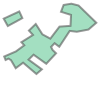

In [46]:
multi[multi.index[0]]

In [51]:
print(list(multi[multi.index[0]]))

[<shapely.geometry.polygon.Polygon object at 0x0000028386E5B2B0>, <shapely.geometry.polygon.Polygon object at 0x0000028386E5B640>]


In [52]:
for i in list(multi[multi.index[0]]):
    print(i)

POLYGON ((77.13884033964518 32.11079102612636, 77.13900931960457 32.11089692023423, 77.13890117243059 32.11101407967274, 77.13908367078669 32.11118981883049, 77.1392616630106 32.11091269169712, 77.13947345122637 32.11079778532473, 77.13971862167551 32.1111196629397, 77.14001359713259 32.11114023879916, 77.14002747833059 32.1114327094429, 77.13975959062424 32.11151651341863, 77.13982943567412 32.11169901177476, 77.14003671775765 32.11173280776664, 77.14022875570129 32.1116840276898, 77.14070331915725 32.11122254219062, 77.140492963648 32.11104111646624, 77.14018204052273 32.11098253674699, 77.13999278296824 32.11100506740824, 77.13971340276872 32.11058149097673, 77.13958723106572 32.11067611975398, 77.13949372882152 32.11057698484449, 77.1395346958023 32.11049356671316, 77.13962665873892 32.11040685351699, 77.13936465112705 32.11012613735099, 77.13902629692626 32.11036864089593, 77.13889095524594 32.11023636631489, 77.13924666094421 32.10997769546931, 77.13910090836539 32.10985276894621

In [41]:
from shapely.geometry import MultiPolygon, Polygon

multipolygon = MultiPolygon([Polygon([(0, 0), (1, 1), (1, 0)]),
                             Polygon([(0, 0), (1, 1), (0, 1)])])

polygons = list(multipolygon)
print(*polygons)
# POLYGON ((0 0, 1 1, 1 0, 0 0)) POLYGON ((0 0, 1 1, 0 1, 0 0))

polygons = list(multipolygon.geoms)
print(*polygons)
# POLYGON ((0 0, 1 1, 1 0, 0 0)) POLYGON ((0 0, 1 1, 0 1, 0 0))

for polygon in multipolygon:  # same for multipolygon.geoms
    print(polygon)

POLYGON ((0 0, 1 1, 1 0, 0 0)) POLYGON ((0 0, 1 1, 0 1, 0 0))
POLYGON ((0 0, 1 1, 1 0, 0 0)) POLYGON ((0 0, 1 1, 0 1, 0 0))
POLYGON ((0 0, 1 1, 1 0, 0 0))
POLYGON ((0 0, 1 1, 0 1, 0 0))


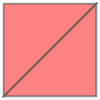

In [42]:
multipolygon

In [3]:
old_apples_shp = gpd.read_file('../data/apples/survey20210716_polygons20210819_corrected20210831.shp')
new_apples_shp = gpd.read_file('../data/apples/survey20210825_polygons20210901.shp')
non_crops_shp = gpd.read_file('../data/non-crops/non-crop.shp')
other_crops_shp = gpd.read_file('../data/other-crops/other-crops.shp')

In [67]:
def merge_shapefiles(to_label_path='../data/all-labels/all-labels.shp'):
    # read all the shape files
    old_apples_shp = gpd.read_file('../data/apples/survey20210716_polygons20210819_corrected20210831.shp')
    new_apples_shp = gpd.read_file('../data/apples/survey20210825_polygons20210901.shp')
    non_crops_shp = gpd.read_file('../data/non-crops/non-crop.shp')
    other_crops_shp = gpd.read_file('../data/other-crops/other-crops.shp')

    # put all shape files into one geo dataframe
    all_labels_shp = gpd.GeoDataFrame(
        pd.concat([old_apples_shp, new_apples_shp, other_crops_shp, non_crops_shp], axis=0))
    all_labels_shp = all_labels_shp.dropna().reset_index(drop=True)  # delete empty polygons

    # mask for the study area
    study_area_shp = gpd.read_file('../data/study-area/study_area.shp')
    labels_in_study = gpd.overlay(all_labels_shp, study_area_shp, how='intersection')
    print(labels_in_study.columns)
    cols2drop = [col for col in ['id', 'id_2'] if col in labels_in_study.columns]
    labels_in_study = labels_in_study.drop(cols2drop, axis=1).rename(columns={'id_1': 'id'})
    labels_in_study.to_file(to_label_path)  # save to folder

In [68]:
merge_shapefiles()

Index(['id_1', 'district', 'id_2', 'geometry'], dtype='object')


In [69]:
labels_shp

,id,district,geometry
0,1,Kullu,"POLYGON ((77.12891 32.05526, 77.12915 32.05533..."
1,1,Kullu,"POLYGON ((77.12858 32.05315, 77.12970 32.05281..."
2,1,Kullu,"POLYGON ((77.12294 32.09258, 77.12255 32.09271..."
3,1,Kullu,"POLYGON ((77.12374 32.09321, 77.12384 32.09305..."
4,1,Kullu,"POLYGON ((77.12481 32.09236, 77.12456 32.09177..."
...,...,...,...
114,3,Kullu,"POLYGON ((77.16702 32.17655, 77.16936 32.17587..."
115,3,Kullu,"POLYGON ((77.07858 32.11814, 77.07902 32.11489..."
116,3,Kullu,"POLYGON ((77.15363 32.11358, 77.15613 32.11337..."
117,3,Kullu,"POLYGON ((77.14874 32.10324, 77.14962 32.10399..."


In [30]:
def get_apples():
    old_apples_shp = gpd.read_file('../data/apples/survey20210716_polygons20210819_corrected20210831.shp')
    new_apples_shp = gpd.read_file('../data/apples/survey20210825_polygons20210901.shp')
    apples_shp = gpd.GeoDataFrame(pd.concat([old_apples_shp, 
                                             new_apples_shp], axis=0).reset_index(drop=True))
    return apples_shp

def get_all_labels(to_label_path='../data/all-labels/all-labels.shp'):
    non_crops_shp = gpd.read_file('../data/non-crops/non-crop.shp')
    other_crops_shp = gpd.read_file('../data/other-crops/other-crops.shp')
    old_apples_shp = gpd.read_file('../data/apples/survey20210716_polygons20210819_corrected20210831.shp')
    new_apples_shp = gpd.read_file('../data/apples/survey20210825_polygons20210901.shp')
    labels_shp = gpd.GeoDataFrame(
        pd.concat([old_apples_shp, new_apples_shp, other_crops_shp, non_crops_shp], axis=0))
    labels_shp = labels_shp.dropna().reset_index(drop=True)
    labels_shp.to_file(to_label_path)        
    return labels_shp

In [14]:
apples_shp = get_apples()

In [15]:
apples_shp

,id,district,geometry
0,1,Shimla,"POLYGON ((77.78505 31.14080, 77.78498 31.14099..."
1,1,Kullu,"POLYGON ((77.12878 32.05505, 77.12891 32.05526..."
2,1,Kullu,"POLYGON ((77.12814 32.05329, 77.12858 32.05315..."
3,1,Kullu,"POLYGON ((77.12329 32.09353, 77.12294 32.09258..."
4,1,Kullu,"POLYGON ((77.12360 32.09328, 77.12374 32.09321..."
...,...,...,...
65,1,Shimla,"POLYGON ((77.95450 31.26796, 77.95480 31.26832..."
66,1,Shimla,"POLYGON ((77.95016 31.24185, 77.95032 31.24223..."
67,1,Shimla,"POLYGON ((77.94937 31.23632, 77.94940 31.23644..."
68,1,Shimla,"POLYGON ((77.94063 31.23868, 77.94157 31.23819..."


In [31]:
labels_shp = get_all_labels()

In [32]:
labels_shp

,id,district,geometry
0,1,Shimla,"POLYGON ((77.78505 31.14080, 77.78498 31.14099..."
1,1,Kullu,"POLYGON ((77.12878 32.05505, 77.12891 32.05526..."
2,1,Kullu,"POLYGON ((77.12814 32.05329, 77.12858 32.05315..."
3,1,Kullu,"POLYGON ((77.12329 32.09353, 77.12294 32.09258..."
4,1,Kullu,"POLYGON ((77.12360 32.09328, 77.12374 32.09321..."
...,...,...,...
146,3,Kullu,"POLYGON ((77.16516 32.17655, 77.16702 32.17655..."
147,3,Kullu,"POLYGON ((77.07689 32.11689, 77.07858 32.11814..."
148,3,Kullu,"POLYGON ((77.15288 32.11233, 77.15363 32.11358..."
149,3,Kullu,"POLYGON ((77.14941 32.10249, 77.14874 32.10324..."


<AxesSubplot:>

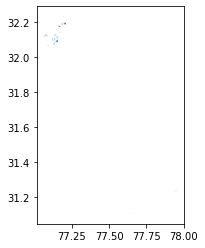

In [36]:
labels_shp.plot()

In [38]:
study_region_shp = gpd.read_file('../data/study-area/study_area.shp')

In [39]:
labels_in_study = gpd.overlay(labels_shp, study_region_shp, how='intersection')

<AxesSubplot:>

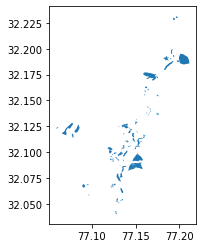

In [40]:
labels_in_study.plot()

In [55]:
labels_in_study.drop(['id', 'id_2'], axis=1).rename(columns={'id_1': 'id'})

,id,district,geometry
0,1,Kullu,"POLYGON ((77.12915 32.05533, 77.12950 32.05517..."
1,1,Kullu,"POLYGON ((77.12970 32.05281, 77.12922 32.05153..."
2,1,Kullu,"POLYGON ((77.12255 32.09271, 77.12268 32.09328..."
3,1,Kullu,"POLYGON ((77.12384 32.09305, 77.12336 32.09255..."
4,1,Kullu,"POLYGON ((77.12456 32.09177, 77.12432 32.09183..."
...,...,...,...
114,3,Kullu,"POLYGON ((77.16936 32.17587, 77.17226 32.17534..."
115,3,Kullu,"POLYGON ((77.07902 32.11489, 77.07880 32.11356..."
116,3,Kullu,"POLYGON ((77.15613 32.11337, 77.15644 32.11410..."
117,3,Kullu,"POLYGON ((77.14962 32.10399, 77.15014 32.10567..."


In [56]:
labels_in_study

,id_1,district,id_2,id,geometry
0,1,Kullu,1,1,"POLYGON ((77.12915 32.05533, 77.12950 32.05517..."
1,1,Kullu,1,1,"POLYGON ((77.12970 32.05281, 77.12922 32.05153..."
2,1,Kullu,1,1,"POLYGON ((77.12255 32.09271, 77.12268 32.09328..."
3,1,Kullu,1,1,"POLYGON ((77.12384 32.09305, 77.12336 32.09255..."
4,1,Kullu,1,1,"POLYGON ((77.12456 32.09177, 77.12432 32.09183..."
...,...,...,...,...,...
114,3,Kullu,1,1,"POLYGON ((77.16936 32.17587, 77.17226 32.17534..."
115,3,Kullu,1,1,"POLYGON ((77.07902 32.11489, 77.07880 32.11356..."
116,3,Kullu,1,1,"POLYGON ((77.15613 32.11337, 77.15644 32.11410..."
117,3,Kullu,1,1,"POLYGON ((77.14962 32.10399, 77.15014 32.10567..."


In [48]:
def load_target_shp(path, transform=None, proj_out=None):
    """ Load the shapefile as a list of numpy array of coordinates
        INPUT : path (str) -> the path to the shapefile
                transform (rasterio.Affine) -> the affine transformation to get the polygon in row;col format from UTM.
        OUTPUT : poly (list of np.array) -> list of polygons (as numpy.array of coordinates)
                 poly_rc (list of np.array) -> list of polygon in row-col format if a transform is given
    """
    with fiona.open(path) as shapefile:
        proj_in = pyproj.Proj(shapefile.crs)
        class_type = [feature['properties']['id'] for feature in shapefile]
        features = [feature["geometry"] for feature in shapefile]
    # reproject polygons if necessary
    if proj_out is None or proj_in == proj_out:
        poly = [np.array([(coord[0], coord[1]) for coord in features[i]['coordinates'][0]]) for i in range(len(features))]
        print('No reprojection!')
    else:
        poly = [np.array([pyproj.transform(proj_in, proj_out, coord[0], coord[1]) for coord in features[i]['coordinates'][0]]) for i in range(len(features))]
        print(f'Reproject from {proj_in} to {proj_out}')
              
    poly_rc = None
    # transform in row-col if a transform is given
    if not transform is None:
        poly_rc = [np.array([rasterio.transform.rowcol(transform, coord[0], coord[1])[::-1] for coord in p]) for p in poly]

    return poly, poly_rc, class_type

def compute_mask(polygon_list, img_w, img_h, val_list):
    """ Get mask of class of a polygon list
        INPUT : polygon_list (list od polygon in coordinates (x, y)) -> the polygons in row;col format
                img_w (int) -> the image width
                img_h (int) -> the image height
                val_list(list of int) -> the class associated with each polygon
        OUTPUT : img (np.array 2D) -> the mask in which the pixel value reflect it's class (zero being the absence of class)
    """
    img = np.zeros((img_h, img_w), dtype=np.uint8) #skimage : row,col --> h,w
    for polygon, val in zip(polygon_list, val_list):
        rr, cc = skimage.draw.polygon(polygon[:,1], polygon[:,0], img.shape)
        img[rr, cc] = val

    return img

In [70]:
# load study area shapefile
_, study_rc_polygons, study_class_list = \
    load_target_shp('../data/study-area/study_area.shp',
                    transform=meta_train['transform'],
                    proj_out=pyproj.Proj(meta_train['crs']))
region_mask = compute_mask(study_rc_polygons, meta_train['width'], meta_train['height'], study_class_list)
# load label shapefile
train_polygons, train_rc_polygons, train_class_list = \
    load_target_shp('../data/all-labels/all-labels.shp',
                    transform=meta_train['transform'],
                    proj_out=pyproj.Proj(meta_train['crs']))
train_mask = compute_mask(train_rc_polygons, meta_train['width'], meta_train['height'], train_class_list)

C:\Users\lida\Anaconda3\envs\ml4sat\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


No reprojection!
No reprojection!


C:\Users\lida\Anaconda3\envs\ml4sat\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [71]:
np.unique(train_mask)

array([0, 1, 2, 3], dtype=uint8)

In [33]:
with fiona.open('../data/apples/survey20210716_polygons20210819_corrected20210831.shp') as shapefile:
    proj_in = pyproj.Proj(shapefile.crs)
    for feature in shapefile:
        print(feature)
    class_type = [feature['properties']['id'] for feature in shapefile]
    features = [feature["geometry"] for feature in shapefile]

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('id', 1), ('district', 'Shimla')]), 'geometry': {'type': 'Polygon', 'coordinates': [[(77.78504972069115, 31.14080404390137), (77.78497871785974, 31.14098974361426), (77.78498600020143, 31.14118090508341), (77.78499510312854, 31.141395734163027), (77.78513457063956, 31.14146777691707), (77.78533737318759, 31.141519533971618), (77.78557769046309, 31.14156504860713), (77.78567418149038, 31.141424863529753), (77.78569238734458, 31.141246446158547), (77.7856141021715, 31.141166340400044), (77.7855886139756, 31.141017052395565), (77.7853410911299, 31.14092012883111), (77.78504972069115, 31.14080404390137)]]}}
{'type': 'Feature', 'id': '1', 'properties': OrderedDict([('id', 1), ('district', 'Kullu')]), 'geometry': {'type': 'Polygon', 'coordinates': [[(77.12878330469185, 32.05504636694745), (77.12890755900995, 32.05526328550276), (77.12914572662964, 32.055327335438385), (77.1294967275282, 32.05517008703583), (77.12957535172949, 32.0551

C:\Users\lida\Anaconda3\envs\ml4sat\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [30]:
with fiona.open('../data/all-labels/all-labels.shp') as shapefile:
    proj_in = pyproj.Proj(shapefile.crs)
    for feature in shapefile:
        print(feature)
    class_type = [feature['id'] for feature in shapefile]
    features = [feature["geometry"] for feature in shapefile]

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('id_1', 1), ('district', 'Kullu'), ('id_2', 1)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(77.12890755900995, 32.05526328550276), (77.12914572662964, 32.055327335438385), (77.1294967275282, 32.05517008703583), (77.12957535172949, 32.05513077493519), (77.12965116792357, 32.05508303881299), (77.12974944817518, 32.05502407066203), (77.1298168403477, 32.05496791051826), (77.12994881668556, 32.054698341828164), (77.1294770714779, 32.05302196153663), (77.12874137359451, 32.05323256207577), (77.1280814919052, 32.05372115532656), (77.12840932674446, 32.05438665303026), (77.12857289316318, 32.054678685777844), (77.12878330469185, 32.05504636694745), (77.12890755900995, 32.05526328550276)], [(77.12943495137007, 32.05483874218761), (77.12970732806735, 32.054774158022276), (77.12971294408173, 32.054931406424835), (77.12949111151384, 32.0550128386333), (77.12943495137007, 32.05483874218761)], [(77.12901936630618, 32.05402442010294)

C:\Users\lida\Anaconda3\envs\ml4sat\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
meta_train = example.meta

# %% load label shapefile
polygons_train, polygons_rc_train, class_list = \
    load_target_shp('../data/all-labels/all-labels.shp', 
                    transform=meta_train['transform'], 
                    proj_out=pyproj.Proj(meta_train['crs']))
mask_train = compute_mask(polygons_rc_train, 
                          meta_train['width'], 
                          meta_train['height'], 
                          class_list)

NameError: name 'example' is not defined

In [ ]:
# %% load label shapefile
_, region_rc_mask, region_list = \
    load_target_shp('../data/study-area/study_area.shp', 
                    transform=meta_train['transform'], 
                    proj_out=pyproj.Proj(meta_train['crs']))
region_mask = compute_mask(region_rc_mask, 
                          meta_train['width'], 
                          meta_train['height'], 
                          region_list)

C:\Users\lida\Anaconda3\envs\ml4sat\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


No reprojection!


In [666]:
count_classes(region_mask)

Number of pixel taking 0 is 2692384
Number of pixel taking 1 is 1767060


### Pair x and y, split train and val

In [56]:
print(f'df = {df.shape[0]}, mask_train = {mask_train.reshape(-1).shape[0]}')

df = 4459444, mask_train = 4459444


In [57]:
df['label'] = mask_train.reshape(-1)

In [58]:
df

,blue_avg,blue_std,blue_max,green_avg,green_std,green_max,red_avg,red_std,red_max,nir_avg,nir_std,nir_max,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4459440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4459441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4459442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [59]:
from sklearn.model_selection import train_test_split

In [66]:
df_train_val = df[df['label'] != 0].reset_index(drop=True)

In [67]:
df_train_val

,blue_avg,blue_std,blue_max,green_avg,green_std,green_max,red_avg,red_std,red_max,nir_avg,nir_std,nir_max,label
0,0.008127,0.006653,0.014405,0.006802,0.005631,0.013016,0.005472,0.004507,0.010208,0.016693,0.013706,0.030457,2
1,0.011026,0.009004,0.018631,0.009262,0.007578,0.016251,0.007944,0.006502,0.013993,0.014356,0.011745,0.025162,2
2,0.011063,0.009036,0.018784,0.009256,0.007569,0.016144,0.007990,0.006543,0.014069,0.014350,0.011739,0.025147,2
3,0.013721,0.011274,0.024125,0.014466,0.011886,0.025452,0.015271,0.012631,0.028031,0.021128,0.017286,0.036454,2
4,0.017697,0.014464,0.030137,0.020224,0.016536,0.035279,0.021128,0.017311,0.037491,0.025715,0.021049,0.044999,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22134,0.005289,0.004516,0.011200,0.007034,0.005839,0.013535,0.006937,0.005710,0.012879,0.023896,0.019532,0.041444,2
22135,0.003201,0.002880,0.007538,0.006207,0.005173,0.012222,0.004678,0.004062,0.010315,0.031318,0.025573,0.052781,2
22136,0.012793,0.010449,0.021759,0.015302,0.012496,0.025910,0.015769,0.012878,0.026612,0.023258,0.018992,0.039139,2
22137,0.007813,0.006534,0.015259,0.009995,0.008242,0.018143,0.009717,0.007995,0.017578,0.026749,0.021856,0.045335,2


In [71]:
x = df_train_val.iloc[:,:-1].values
y = df_train_val.label.values

In [74]:
x, y

(array([[0.00812696, 0.00665308, 0.01440452, ..., 0.01669337, 0.01370629,
         0.03045701],
        [0.01102617, 0.00900433, 0.01863127, ..., 0.01435569, 0.01174535,
         0.02516213],
        [0.01106279, 0.00903639, 0.01878386, ..., 0.01434958, 0.01173934,
         0.02514687],
        ...,
        [0.01279316, 0.01044877, 0.02175937, ..., 0.0232578 , 0.01899159,
         0.03913939],
        [0.00781262, 0.00653378, 0.01525902, ..., 0.02674907, 0.02185608,
         0.04533455],
        [0.01212482, 0.0099105 , 0.02095064, ..., 0.02178378, 0.01778764,
         0.03668269]]),
 array([2, 2, 2, ..., 2, 2, 2], dtype=uint8))

In [106]:
def count_classes(y):
    for i in np.unique(y):
        print(f'Number of pixel taking {i} is {y[y==i].shape[0]}')

In [107]:
count_classes(y)

Number of pixel taking 1 is 4391
Number of pixel taking 2 is 17748


In [90]:
x_train, x_val, y_train, y_val = \
    train_test_split(x, y, test_size=0.2, random_state=42)

### Train models

In [81]:
from sklearn.cluster import KMeans
from skimage.color import label2rgb

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [675]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

#### SVM

In [86]:
svm = SVC()

In [88]:
svm.fit(x_train, y_train)

SVC()

In [91]:
svm.score(x_val, y_val)

0.935862691960253

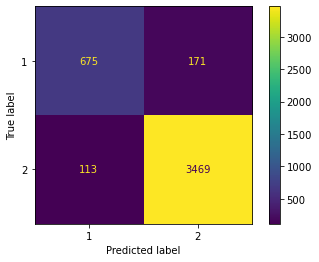

In [677]:
plot_confusion_matrix(svm, x_val, y_val)

#### Random forest

In [92]:
rfc = RandomForestClassifier()

In [93]:
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [94]:
rfc.score(x_val, y_val)

0.9625112917795845

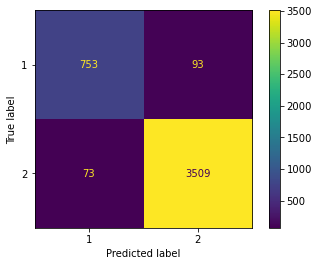

In [676]:
plot_confusion_matrix(rfc, x_val, y_val)

In [98]:
def plot_feature_importance(columns, feature_importance, save_path=None):
    plt.bar(columns, feature_importance)
    plt.xticks(rotation = 45)
    if save_path is not None:
        plt.savefig(save_path)

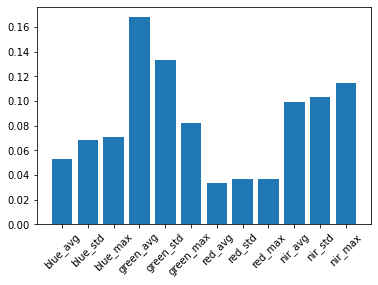

In [99]:
plot_feature_importance(df_train_val.columns[:-1], rfc.feature_importances_)

In [101]:
rfc.predict(x_val)

array([2, 2, 2, ..., 2, 1, 2], dtype=uint8)

In [104]:
pred = rfc.predict(df.iloc[:,:-1].values)

In [108]:
count_classes(pred)

Number of pixel taking 1 is 454496
Number of pixel taking 2 is 4004948


### Visualization

In [136]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patches as mpatches

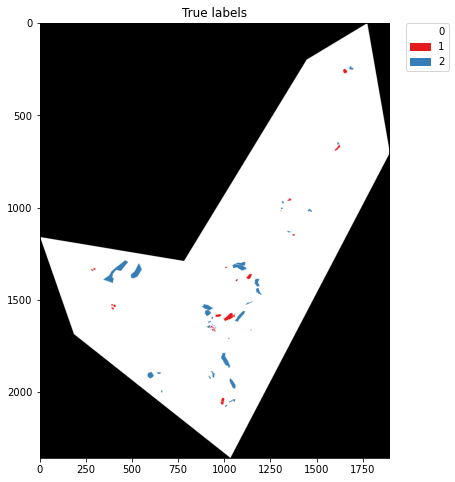

In [680]:
plot(mask_train, region_mask, 'True labels')

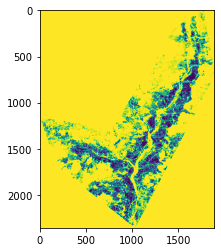

In [681]:
plt.imshow(pred.reshape(meta_train['height'], meta_train['width']))

In [241]:
pred

array([2, 2, 2, ..., 2, 2, 2], dtype=uint8)

In [243]:
pred_ = pred.copy()
pred_[df.label == 0] = 0

In [245]:
count_classes(pred_)

Number of pixel taking 0 is 4437305
Number of pixel taking 1 is 4371
Number of pixel taking 2 is 17768


In [249]:
label = df.label.to_numpy()

In [772]:
def get_mycmap(num_colors):
    cmap = 'Set1'
    if num_colors < len(mpl.cm.get_cmap(cmap).colors):
        colors_list = [np.array([1,1,1])]
        [colors_list.append(np.array(c)) for c in mpl.cm.get_cmap(cmap).colors[:num_colors]]
        mycmap = mpl.colors.ListedColormap(colors_list)
        mycmap.set_under(color='white')
        mycmap.set_bad(color='black')
        return mycmap
    else:
        return 'Set too many colors'

    
def map_values_to_colors(values, mycmap):
    # map values 
    norm = mpl.colors.Normalize(vmin=0, vmax=2, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=mycmap)
    mapped = mapper.to_rgba(values)
    
    # get the mapping of values to colors 
    maps = {}
    for v in range(int(mapper.get_clim()[0]), int(mapper.get_clim()[1])+1):
        maps[v] = mapper.get_cmap().colors[v]
        
    return mapped, maps


# def plot(classes_array, title):
#     fig = plt.subplots(figsize=(10,8))
#     im = plt.imshow(classes_array, vmin=0.01, vmax=len(mycmap.colors)+1,
#                     cmap=mycmap, interpolation=None)
#     values = np.unique(classes_array)
#     print(values)
#     # get the colors of the values, according to the 
#     # colormap used by imshow
#     colors = [im.cmap(im.norm(value)) for value in values]
#     # create a patch (proxy artist) for every color 
#     patches = [mpatches.Patch(color=colors[i], label="{l}".format(l=values[i]) ) for i in range(len(values)) ]
#     # put those patched as legend-handles into the legend
#     plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
#     plt.title(title)


def show_mask(classes_array, region_mask, title, windows=None):
    # get my color map
    mycmap = get_mycmap(2)

    # get the mapped colors
    mapped_colors, v2c = map_values_to_colors(classes_array, mycmap)
    mapped_colors[region_mask == 0] = np.array([0,0,0,1])
    
    # show images 
    fig = plt.subplots(figsize=(10,8))
    if windows is None:
        im = plt.imshow(mapped_colors, cmap=mycmap, interpolation=None)
    else:
        im = plt.imshow(mapped_colors, cmap=mycmap, interpolation=None)
    # create a patch (proxy artist) for every color 
    patches = [mpatches.Patch(color=v2c[v], label=f"{v}") for v in v2c]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.title(title)

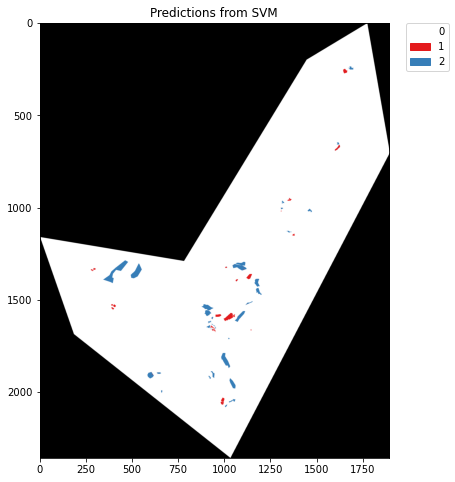

In [671]:
plot(pred_.reshape(meta_train['height'], meta_train['width']), region_mask, 'Predictions from SVM')

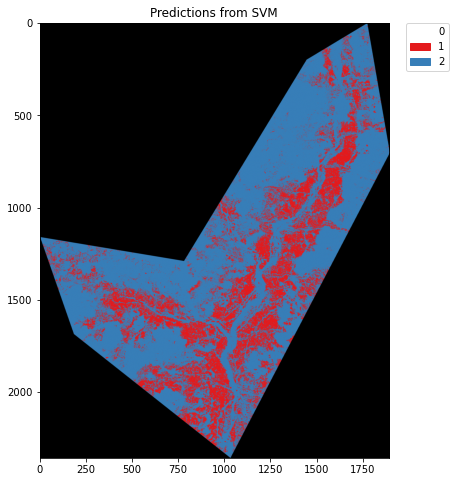

In [672]:
plot(pred.reshape(meta_train['height'], meta_train['width']), region_mask, 'Predictions from SVM')

#### show true color images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


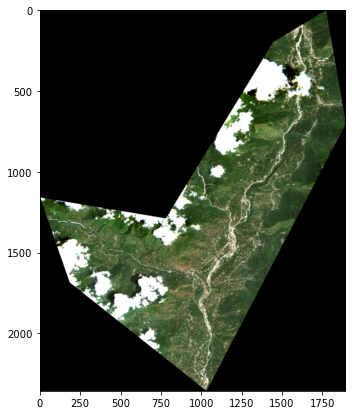

In [709]:
img_eg_path = img_dir + 'clip/L2A_T43SFR_A026271_20200703T053446.tiff'
img_eg = rasterio.open(img_eg_path)
img_eg_rgb = show_true_color(img_eg, is_norm=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


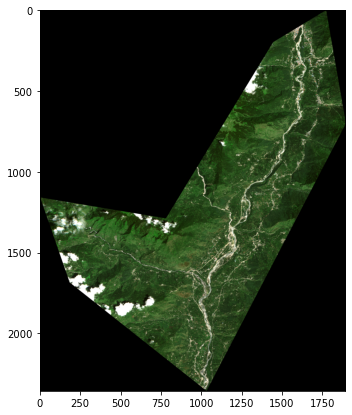

In [708]:
img_eg_path = img_dir + 'clip/L2A_T43SFR_A026557_20200723T053824.tiff'
img_eg = rasterio.open(img_eg_path)
img_eg_rgb = show_true_color(img_eg, is_norm=True)

(array([1.708609e+06, 3.396600e+04, 8.922000e+03, 7.165000e+03,
        4.818000e+03, 1.600000e+03, 1.970000e+02, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([1.00000e+00, 1.37150e+03, 2.74200e+03, 4.11250e+03, 5.48300e+03,
        6.85350e+03, 8.22400e+03, 9.59450e+03, 1.09650e+04, 1.23355e+04,
        1.37060e+04]),
 <BarContainer object of 10 artists>)

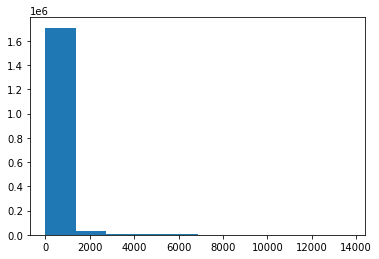

In [704]:
plt.hist(blue[blue!=0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


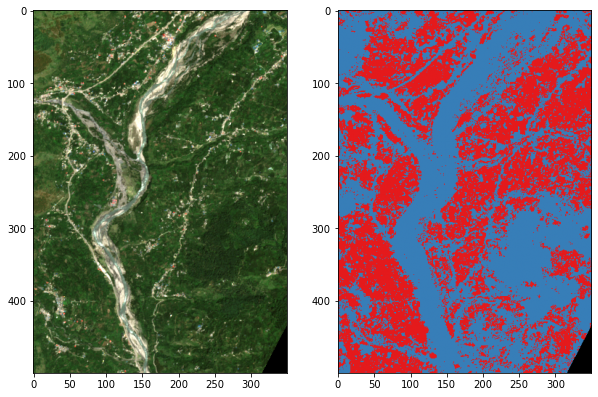

In [722]:
fig, axs = plt.subplots(1,2, figsize=(10,7))

# plot true color images
img_eg_path = img_dir + 'clip/L2A_T43SFR_A026557_20200723T053824.tiff'
img_eg = rasterio.open(img_eg_path)
blue = img_eg.read(1)
green = img_eg.read(2)
red = img_eg.read(3)
blue_norm = normalize(blue)
green_norm = normalize(green)
red_norm = normalize(red)
img_rgb = np.dstack((red_norm, green_norm, blue_norm))
axs[0].imshow(img_rgb[1500:2000, 900:1250])

# plot predicted results 
mycmap = get_mycmap(2)
mapped_colors, v2c = map_values_to_colors(pred.reshape(meta_train['height'], meta_train['width']), mycmap)
mapped_colors[region_mask == 0] = np.array([0,0,0,1])
axs[1].imshow(mapped_colors[1500:2000, 900:1250], cmap=mycmap, interpolation=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


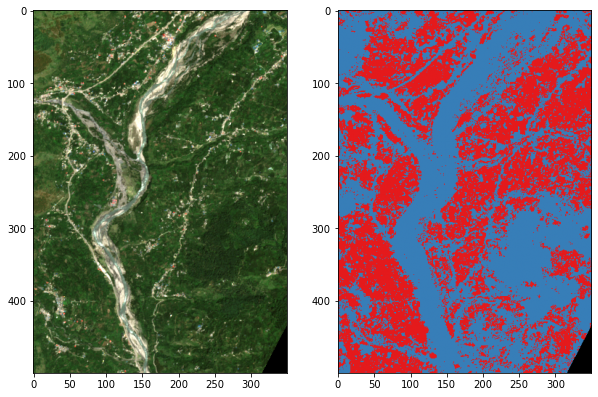

In [746]:
fig, axs = plt.subplots(1,2, figsize=(10,7))

# plot true color images
img_eg_path = img_dir + 'clip/L2A_T43SFR_A026557_20200723T053824.tiff'
img_eg = rasterio.open(img_eg_path)
blue = img_eg.read(1)
green = img_eg.read(2)
red = img_eg.read(3)
blue_norm = normalize(blue)
green_norm = normalize(green)
red_norm = normalize(red)
img_rgb = np.dstack((red_norm, green_norm, blue_norm))
axs[0].imshow(img_rgb[1500:2000, 900:1250])

# plot predicted results 
mycmap = get_mycmap(2)
mapped_colors, v2c = map_values_to_colors(pred.reshape(meta_train['height'], meta_train['width']), mycmap)
mapped_colors[region_mask == 0] = np.array([0,0,0,1])
axs[1].imshow(mapped_colors[1500:2000, 900:1250], cmap=mycmap, interpolation=None)

# plt.savefig('../figs/side_by_side.pdf')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


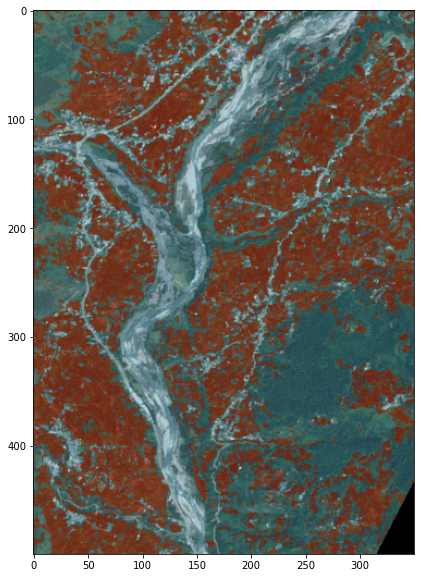

In [748]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.imshow(img_rgb[1500:2000, 900:1250])
plt.imshow(mapped_colors[1500:2000, 900:1250], cmap=mycmap, interpolation=None, alpha=0.4)
# plt.savefig('../figs/single_figure.pdf')

#### Save predictions to tiff

In [800]:
def save_pred_geotiff(meta_src, pred, save_path):
    # Register GDAL format drivers and configuration options with a context manager
    with rasterio.Env():
        # Write an array as a raster band to a new 8-bit file. We start with the profile of the source
        out_meta = meta_src.copy()
        out_meta.update(
            dtype=rasterio.uint8,
            count=1,
            compress='lzw')
        with rasterio.open(save_path, 'w', **out_meta) as dst:
            # reshape into (band, height, width)
            dst.write(pred.reshape(1, out_meta['height'], out_meta['width']).astype(rasterio.uint8))

In [767]:
save_pred_geotiff(meta_train, pred, '../preds/preds_rf_original.tif')

(4, 2357, 1892)

#### Morphological treatment 

In [770]:
from skimage.morphology import disk, binary_closing, binary_opening 

In [781]:
count_classes(pred)

Number of pixel taking 1 is 454496
Number of pixel taking 2 is 4004948


In [788]:
pred_vis = pred.copy()
pred_vis[pred_vis == 2] = 0
count_classes(pred_vis)

Number of pixel taking 0 is 4004948
Number of pixel taking 1 is 454496


In [783]:
disk(2)

array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [802]:
pred_closed_disk2 = binary_closing(pred_vis.reshape(meta_train['height'], meta_train['width']), 
                                   selem=disk(2)).astype(int)
pred_closed_disk1 = binary_closing(pred_vis.reshape(meta_train['height'], meta_train['width']), 
                                   selem=disk(1)).astype(int)
pred_opened_disk2 = binary_opening(pred_closed_disk2, selem=disk(2)).astype(int)
pred_opened_disk1 = binary_opening(pred_closed_disk1, selem=disk(2)).astype(int)

In [803]:
count_classes(pred_closed_disk2)
count_classes(pred_closed_disk1)
count_classes(pred_opened_disk2)
count_classes(pred_opened_disk1)

Number of pixel taking 0 is 3817610
Number of pixel taking 1 is 641834
Number of pixel taking 0 is 3919065
Number of pixel taking 1 is 540379
Number of pixel taking 0 is 3867923
Number of pixel taking 1 is 591521
Number of pixel taking 0 is 4015095
Number of pixel taking 1 is 444349


In [813]:
pred_closed_square = binary_closing(pred_vis.reshape(meta_train['height'], meta_train['width']), 
                                   selem=np.ones(4, dtype=np.uint8).reshape(2,2)).astype(int)
count_classes(pred_closed_square)

Number of pixel taking 0 is 3942773
Number of pixel taking 1 is 516671


In [814]:
pred_opened_square = binary_opening(pred_vis.reshape(meta_train['height'], meta_train['width']), 
                                   selem=np.ones(4, dtype=np.uint8).reshape(2,2)).astype(int)
count_classes(pred_opened_square)

Number of pixel taking 0 is 4086509
Number of pixel taking 1 is 372935


In [817]:
pred_closed2_square = binary_closing(pred_opened_square, selem=np.ones(4, dtype=np.uint8).reshape(2,2)).astype(int)
count_classes(pred_closed2_square)

Number of pixel taking 0 is 4062354
Number of pixel taking 1 is 397090


Text(0.5, 1.0, 'Opened predictions (disk=1)')

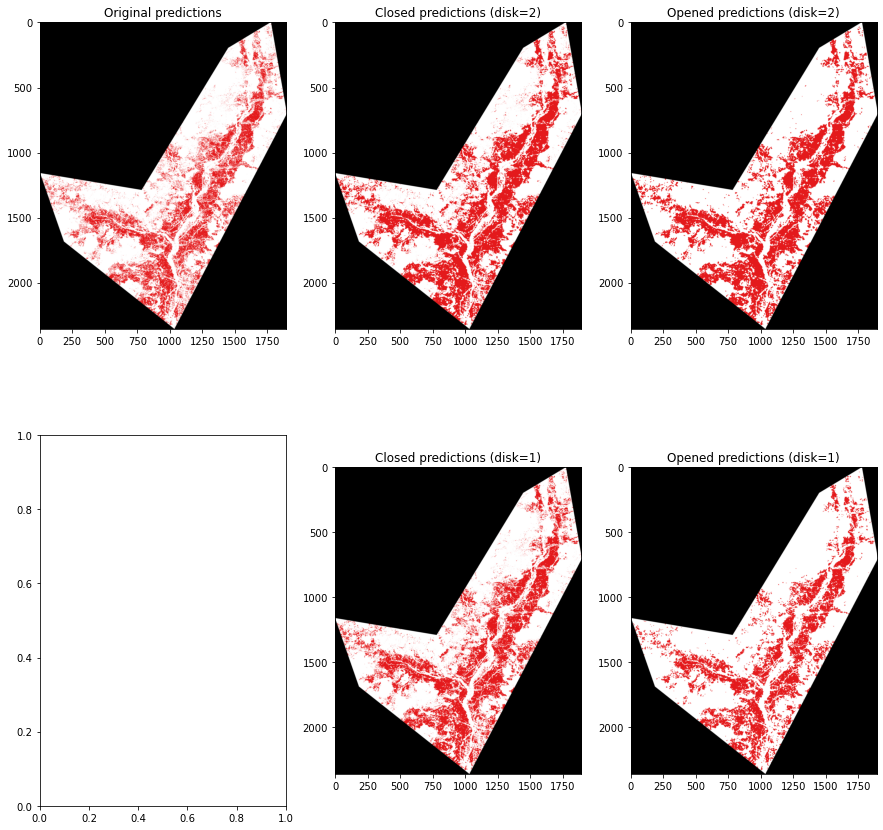

In [804]:
fig, axs = plt.subplots(2,3, figsize=(15,15))

# plot salt-peper results 
mycmap = get_mycmap(2)
mapped_colors, v2c = map_values_to_colors(pred_vis.reshape(meta_train['height'], meta_train['width']), mycmap)
mapped_colors[region_mask == 0] = np.array([0,0,0,1])
axs[0][0].imshow(mapped_colors, cmap=mycmap, interpolation=None)
axs[0][0].set_title('Original predictions')

# plot smoothed_int results
mapped_colors, v2c = map_values_to_colors(pred_closed_disk2.reshape(meta_train['height'], meta_train['width']), mycmap)
mapped_colors[region_mask == 0] = np.array([0,0,0,1])
axs[0][1].imshow(mapped_colors, cmap=mycmap, interpolation=None)
axs[0][1].set_title('Closed predictions (disk=2)')

# plot smoothed
mapped_colors, v2c = map_values_to_colors(pred_opened_disk2.reshape(meta_train['height'], meta_train['width']), mycmap)
mapped_colors[region_mask == 0] = np.array([0,0,0,1])
axs[0][2].imshow(mapped_colors, cmap=mycmap, interpolation=None)
axs[0][2].set_title('Opened predictions (disk=2)')

# plot smoothed_int results
mapped_colors, v2c = map_values_to_colors(pred_closed_disk1.reshape(meta_train['height'], meta_train['width']), mycmap)
mapped_colors[region_mask == 0] = np.array([0,0,0,1])
axs[1][1].imshow(mapped_colors, cmap=mycmap, interpolation=None)
axs[1][1].set_title('Closed predictions (disk=1)')

# plot smoothed
mapped_colors, v2c = map_values_to_colors(pred_opened_disk1.reshape(meta_train['height'], meta_train['width']), mycmap)
mapped_colors[region_mask == 0] = np.array([0,0,0,1])
axs[1][2].imshow(mapped_colors, cmap=mycmap, interpolation=None)
axs[1][2].set_title('Opened predictions (disk=1)')

In [805]:
save_pred_geotiff(meta_train, pred_closed_disk1, '../preds/pred_rf_closed_disk1.tif')
save_pred_geotiff(meta_train, pred_closed_disk2, '../preds/pred_rf_closed_disk2.tif')
save_pred_geotiff(meta_train, pred_opened_disk1, '../preds/pred_rf_opened_disk1.tif')
save_pred_geotiff(meta_train, pred_opened_disk2, '../preds/pred_rf_opened_disk2.tif')

In [816]:
save_pred_geotiff(meta_train, pred_opened_square, '../preds/pred_rf_opened_square.tif')
save_pred_geotiff(meta_train, pred_closed_square, '../preds/pred_rf_closed_square.tif')

In [818]:
save_pred_geotiff(meta_train, pred_closed2_square, '../preds/pred_rf_closed2_square.tif')

### Unsupervised learning

In [ ]:
def cluster(x, k=3):
    # x
    patch_x = x.reshape(-1, x.shape[-1])
    # fit 
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(patch_x)
    # y
    patch_y_pred = kmeans.labels_
    patch_y_pred = patch_y_pred.reshape(x.shape[0], x.shape[1])
    # draw image 
    out = label2rgb(patch_y_pred)
    print(f"x.shape {patch_x.shape}, y_pred.shape {patch_y_pred.shape}, num_cluster {k}")
    return out

In [84]:
out = cluster(df.to_numpy().reshape['height'], meta['width'], 3)

NameError: name 'meta' is not defined

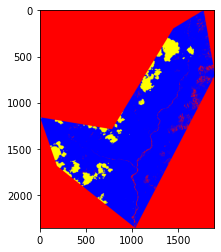

In [175]:
plt.imshow(out)

In [1]:
import re

In [2]:
re.pattern('ndvi_1')

AttributeError: module 're' has no attribute 'pattern'

In [11]:
'ndvi_1'.endswith()

TypeError: unsupported operand type(s) for &: 'str' and 'int'